# Neuroscope

Jupyter workspace for the neuroscope project

In [126]:
import jax
from jax import vmap, jit, lax, random, grad, value_and_grad
import jax.numpy as jnp
import optax
import jraph

import wandb
import numpy as np
from functools import partial
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt

import syrkis
from src.data import load_subjects, make_kfolds
from src.fmri import get_bold_with_coords_and_faces

In [127]:
# GLOBALS
rng = random.PRNGKey(0)
cfg = syrkis.train.load_config()['neuroscope']
opt = optax.adamw(learning_rate=cfg['lr'])

## Data

In [128]:
subjects = load_subjects(['subj05', 'subj07'], cfg['image_size'])
n_samples = sum([len(s[0]) for s in subjects.values()])
kfolds = make_kfolds(subjects, cfg)
train_batches, eval_batches = next(kfolds)
lh_sample, rh_sample, img_sample, subject_idx_sample = next(train_batches)

## fmri

In [129]:
lh = subjects['subj05'][0][0]
coords, features, faces = get_bold_with_coords_and_faces(lh, 'subj05', 'lh')
senders = faces[:, 0] + faces[:, 1] + faces[:, 2]
receivers = faces[:, 1] + faces[:, 2] + faces[:, 0]
n_node, n_edge = jnp.array([features.shape[0]]), jnp.array([senders.shape[0]])
graph = jraph.GraphsTuple(
    n_node=n_node, n_edge=n_edge, edges=None, globals=None,
    nodes=features, senders=senders, receivers=receivers)
meta = subjects['subj05'][-1]
meta[4]


(379470,
 ['umbrella', 'chair', 'chair', 'chair', 'dining table', 'chair'],
 ['A patio table surrounded by chairs on a patio.',
  'a wooden table with 4 chairs and an umbrella\n',
  'wooden patio set with umbrella in a backyard',
  'A table with umbrella and chairs sits on a patio.',
  'Patio table with umbrella surrounded by chairs in the back yeard'])

## utils

In [130]:
def latent_side_fn(cfg):
    return cfg['image_size'] // cfg['stride'] ** cfg['conv_layers']


def latent_dim_fn(cfg):
    # should return the size of the loatente dim depending on initial image size, stride, and number of layers, and channels
    channels = cfg['chan_start']
    # calulate latent channels
    latent_channels = int(channels * (cfg['conv_branch'] ** (cfg['conv_layers'] - 1)))
    # calculate latent side
    latent_side = latent_side_fn(cfg)
    # calculate latent dim
    latent_dim = latent_channels * latent_side ** 2
    return latent_dim
        


latent_dim = latent_dim_fn(cfg)
latent_side = latent_side_fn(cfg)
print(latent_side)
print(latent_dim)

4
3072


## Batch norm

In [131]:
@jit
def batch_norm(x, gamma, beta, eps=1e-5):
    if not cfg['batch_norm']:
        return x
    # x: batch x height x width x channels
    axis = tuple(range(len(x.shape) - 1))
    mean = jnp.mean(x, axis=axis, keepdims=True)
    var = jnp.var(x, axis=axis, keepdims=True)
    x = (x - mean) / jnp.sqrt(var + eps)
    x = gamma * x + beta
    return x

def init_batch_norm(shape):
    shape = [1 for _ in range(len(shape) - 1)] + [shape[-1]]
    shape = tuple(shape)
    gamma = jnp.ones(shape)
    beta = jnp.zeros(shape)
    return gamma, beta

## Linear layer

In [132]:
def init_linear_layer(rng, in_dim, out_dim, tensor_dim):
    # tensor dim is for having fmri embedding in same array, but seperate layers.
    rng, key = jax.random.split(rng, 2)
    w_shape = (in_dim, out_dim)
    b_shape = (out_dim,)
    w = syrkis.train.glorot_init(key, w_shape)
    if tensor_dim > 0:
        w = w.reshape((-1, out_dim, tensor_dim))
    b = jnp.zeros(b_shape)
    gamma, beta = init_batch_norm(b_shape)
    return w, b, gamma, beta

def init_linear_layers(rng, in_dim, out_dim, cfg, tensor_dim=0):
    # first layer goes from in_dim to embed_dim, rest are embed to embed, and last is embed to out
    rngs = jax.random.split(rng, cfg['fc_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        layer_in_dim  = cfg['embed_dim'] if idx != 0                    else in_dim
        layer_out_dim = cfg['embed_dim'] if idx != cfg['fc_layers'] - 1 else out_dim
        params.append(init_linear_layer(rng, layer_in_dim, layer_out_dim, tensor_dim))
    return params

def linear(params, x):
    for idx, (w, b, gamma, beta) in enumerate(params):
        x = x @ w + b
        x = jax.nn.gelu(x) if idx != len(params) - 1 else x
        x = batch_norm(x, gamma, beta) if idx != len(params) - 1 else x
    return x

def test_linear():
    cfg = syrkis.train.load_config()
    cfg = cfg[dataset]
    rng = jax.random.PRNGKey(0)
    x = jnp.array([1.0, 2.0])
    params = init_linear_layers(rng, 2, 4, cfg)
    y = linear(params, x)
    assert y.shape == (4,)
    print(y)

test_linear()

[-1.9884775   0.638638    1.3899286  -0.11827302]


## Convolutions

In [133]:
# Global constants for common parameters
DIMENSION_NUMBERS = ("NHWC", "HWIO", "NHWC")


@jit
def conv2d(x, w):
    return jax.lax.conv_general_dilated(
        x, w, 
        window_strides=(cfg['stride'], cfg['stride']),
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS)


@jit
def upscale_nearest_neighbor(x, scale_factor=cfg['stride']):
    # Assuming x has shape (batch, height, width, channels)
    b, h, w, c = x.shape
    x = x.reshape(b, h, 1, w, 1, c)
    x = lax.tie_in(x, jnp.broadcast_to(x, (b, h, scale_factor, w, scale_factor, c)))
    return x.reshape(b, h * scale_factor, w * scale_factor, c)


@jit
def deconv2d(x, w):
    x_upscaled = upscale_nearest_neighbor(x)
    return lax.conv_transpose(
        x_upscaled, w, 
        strides=(1, 1), 
        padding='SAME',
        dimension_numbers=DIMENSION_NUMBERS) 


def conv_fn(fn):
    def apply_fn(params, x):
        for i, (w, b, gamma, beta) in enumerate(params):
            x = fn(x, w, b)
            x = batch_norm(x, gamma, beta) if i != len(params) - 1 else x
            # x = jax.nn.tanh(x) if i != len(params) - 1 else x
            x = jax.nn.gelu(x) if i != len(params) - 1 else x
        return x
    return apply_fn


conv   = conv_fn(lambda x, w, b: conv2d(x, w) + b)
deconv = conv_fn(lambda x, w, b: deconv2d(x, w) + b)


def init_conv_params(rng, in_chan, out_chan, cfg, deconv=False):
    if deconv:
        in_chan, out_chan = out_chan, in_chan
    rng, key = jax.random.split(rng, 2)
    w_shape = (cfg['kernel_size'], cfg['kernel_size'], in_chan, out_chan)
    w = syrkis.train.glorot_init(key, w_shape)
    b = jnp.zeros((out_chan,))
    gamma, beta = init_batch_norm(b.shape)
    return w, b, gamma, beta


def init_conv_layers(rng, cfg, deconv=False):
    rngs = jax.random.split(rng, cfg['conv_layers'])
    params = []
    for idx, rng in enumerate(rngs):
        in_chan = cfg['in_chans'] if idx == 0 else cfg['chan_start'] * (cfg['conv_branch'] ** (idx - 1))
        out_chan = cfg['chan_start'] * (cfg['conv_branch'] ** idx)
        params.append(init_conv_params(rng, in_chan, out_chan, cfg, deconv))
    return params[::-1] if deconv else params


def test_conv():
    cfg = syrkis.train.load_config()
    cfg = cfg[dataset]
    x = jnp.ones((cfg['batch_size'], cfg['image_size'], cfg['image_size'], cfg['in_chans']))
    conv_params = init_conv_layers(jax.random.PRNGKey(0), cfg)
    deconv_params = init_conv_layers(jax.random.PRNGKey(0), cfg, deconv=True)
    z = conv(conv_params, x)
    print(z.shape, conv_params[1][0].shape)

test_conv()

(64, 4, 4, 192) (3, 3, 24, 48)


## Model

In [134]:
def print_model(params):
    print(f'{syrkis.train.n_params(params)} total params', end='\n\n')
    print('\tconv params')
    for idx, (w, b, gamma, beta) in enumerate(params['conv']):
        print(f'\t\tconv_{idx}\t\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
        print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    print('\n\tlinear params')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_encode']):
        print(f'\t\tencode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
        print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')

In [135]:

def dropout(x, rate, rng):
    rate = 1.0 - rate
    keep = random.bernoulli(rng, rate, x.shape)
    return jnp.where(keep, x / rate, 0)

def encode_img_fn(params, img, rng=None):
    z = jax.nn.tanh(conv(params['conv'], img))
    z = dropout(z, cfg['dropout'], rng) if rng is not None else z
    z = z.reshape(cfg['batch_size'], -1)
    z = jax.nn.tanh(linear(params['linear_encode'], z))
    mu, logvar = jnp.split(z, 2, axis=-1) if cfg['vae'] else (z, z)
    return mu, logvar

def matmul_slice(A, B_slice):
    return jnp.dot(A, B_slice)
batched_matmul = vmap(matmul_slice, in_axes=(None, 2))

def encode_fmri_fn(params, fmri, subj):
    embed_cube = params['fmri_embed'][0][0]            # fmri_dim  x embed_dim x n_subjects
    z = batched_matmul(fmri, embed_cube)               # n_subjects x batch_size x embed_dim
    z = z.transpose((2, 0, 1))                         # embed_dim x n_subjects x batch_size    # prep for broadcast
    one_hot = jax.nn.one_hot(subj, len(subjects)).T    # n_subjects x batch_size                # prep for broadcast
    z = one_hot * z                                    # embed_dim x n_subjects x batch_size    # one subject dimension has zeros after broadcast
    z = z.sum(axis=1).T                                # batch_size x embed_dim                 # sum over subjects
    z = jax.nn.tanh(linear(params['fmri_dense'], z))
    return z

@jit
def decode_fn(params, z, rng=None):
    z = jax.nn.tanh(linear(params['linear_decode'], z))
    z = dropout(z, cfg['dropout'], rng) if rng is not None else z
    z = z.reshape(cfg['batch_size'], latent_side, latent_side, -1)
    z = deconv(params['deconv'], z)
    z = jax.nn.sigmoid(z)
    return z

def reparametrize(mu, logvar, rng):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, mu.shape)
    return mu + eps * std

def apply_fn(params, fmri, img, subj, rng=None, variational=False):
    keys = jax.random.split(rng, 4) if rng is not None else (None, None, None, None)
    mu, logvar = encode_img_fn(params, img, keys[0]) if cfg['source'] == 'img' else (None, None)
    z = mu if not variational and rng is None else reparametrize(mu, logvar, keys[1])
    z = dropout(z, cfg['dropout'], keys[2]) if rng is not None else z
    x_hat = decode_fn(params, z, keys[3])
    return x_hat, (mu, logvar)

apply_non_variational = jit(partial(apply_fn, variational=False))

def kl_divergence(mu, logvar):
    sigma = jnp.exp(0.5 * logvar)
    return jnp.mean(-0.5 * jnp.sum(1 + logvar - mu ** 2 - sigma ** 2, axis=-1))


# This function returns the total loss and its components (recon and KL losses).
def loss_and_components(params, fmri, img, subj, rng=None, variational=False):
    x_hat, (mu, sigma) = apply_fn(params, fmri, img, subj, rng, variational)
    recon_loss = jnp.mean(jnp.abs((img - x_hat))) if cfg['loss_fn'] == 'l1' else jnp.mean((img - x_hat) ** 2)
    kl_loss = kl_divergence(mu, sigma) if rng is not None else 0
    total_loss = recon_loss + kl_loss * cfg['beta'] if variational else recon_loss
    return total_loss, (recon_loss, kl_loss)

# This function only returns the total loss, which is needed for gradient computation.
def loss_fn(params, fmri, img, subj, rng=None, variational=False):
    total_loss, _ = loss_and_components(params, fmri, img, subj, rng, variational)
    return total_loss

def update_fn(params, fmri, img, subj, opt_state, rng, variational):
    # Get the loss, aux data (recon_loss, kl_loss), and gradients
    (total_loss, (recon_loss, kl_loss)), grads = value_and_grad(loss_and_components, has_aux=True)(params, fmri, img, subj, rng, variational)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, total_loss, recon_loss, kl_loss

update_train = jit(partial(update_fn, variational=cfg['vae']))


def init_fn(rng, cfg):

    if dataset == 'mnist' or cfg['source'] == 'img':
        conv_params = init_conv_layers(rng, cfg)
        linear_encode_params = init_linear_layers(rng, latent_dim, cfg['embed_dim'] * 2 if cfg['vae'] else cfg['embed_dim'], cfg)  # linear layers
        linear_decode_params = init_linear_layers(rng, cfg['embed_dim'], latent_dim, cfg)  # linear layers
        deconv_params = init_conv_layers(rng, cfg, deconv=True)
        params = {"conv": conv_params, "deconv": deconv_params,
                  "linear_encode": linear_encode_params, "linear_decode": linear_decode_params}

    if dataset != 'mnist' and cfg['source'] == 'fmri':
        fmri_embed_params = init_linear_layers(rng, 19004 * len(subjects), cfg['embed_dim'], cfg, tensor_dim=len(subjects))  # linear layers
        fmri_dense_params = init_linear_layers(rng, cfg['embed_dim'], cfg['embed_dim'], cfg)  # linear layers
        linear_decode_params = init_linear_layers(rng, cfg['embed_dim'], latent_dim, cfg)  # linear layers
        deconv_params = init_conv_layers(rng, cfg, deconv=True)
        params = {"fmri_embed": fmri_embed_params, "fmri_dense": fmri_dense_params,
                  "deconv": deconv_params, "linear_decode": linear_decode_params}

    return params


def print_model(params):
    print(f'{syrkis.train.n_params(params)} total params', end='\n\n')
    if dataset == 'mnist' or cfg['source'] == 'img':
        print('\tconv params')
        for idx, (w, b, gamma, beta) in enumerate(params['conv']):
            print(f'\t\tconv_{idx}\t\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
            print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        print('\n\tlinear params')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_encode']):
            print(f'\t\tencode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
            print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
    if dataset != 'mnist' and cfg['source'] == 'fmri':
        print('\tfmri params')
        for idx, (w, b, gamma, beta) in enumerate(params['fmri_embed']):
            print(f'\t\tfmri_embed_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['fmri_dense']):
            print(f'\t\tfmri_dense_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['linear_decode']):
            print(f'\t\tdecode_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')
        for idx, (w, b, gamma, beta) in enumerate(params['deconv']):
            print(f'\t\tdeconv_{idx}\t: {w.size + b.size}\t|\t{str(w.shape).replace(", ", " x ")[1:-1]}')



## Training

In [136]:
rng = jax.random.PRNGKey(0)
# params = init_fn(rng, cfg)
n_params = syrkis.train.n_params(params)
opt_state = opt.init(params)
print_model(params)

1234377 total params

	conv params
		conv_0		: 672	|	3 x 3 x 3 x 24
		conv_1		: 10416	|	3 x 3 x 24 x 48
		conv_2		: 41568	|	3 x 3 x 48 x 96
		conv_3		: 166080	|	3 x 3 x 96 x 192
		deconv_0	: 165984	|	3 x 3 x 192 x 96
		deconv_1	: 41520	|	3 x 3 x 96 x 48
		deconv_2	: 10392	|	3 x 3 x 48 x 24
		deconv_3	: 651	|	3 x 3 x 24 x 3

	linear params
		encode_0	: 393344	|	3072 x 128
		decode_0	: 396288	|	128 x 3072



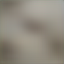
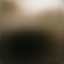
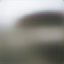
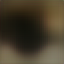
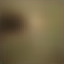
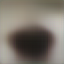
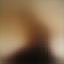
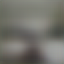

In [137]:
def evaluate(params, train_batches, eval_batches, eval_steps=5):
    train_loss, eval_loss = 0, 0
    for i in range(eval_steps):
        _, _, train_img, _ = next(train_batches)
        _, _, eval_img, _ = next(eval_batches)
        train_loss += loss_fn(params, None, train_img, None) / eval_steps
        eval_loss += loss_fn(params, None, eval_img, None) / eval_steps
    return train_loss, eval_loss

def static_info(cfg):
    return [
        f"n_params : {n_params}",
        f"dropout : {cfg['dropout']}",
        f"lr : {cfg['lr']}",
        f"loss : {cfg['loss_fn']}",
        f"embed_dim : {cfg['embed_dim']}",
        f"beta : {cfg['beta']}",
        f"batch_size : {cfg['batch_size']}",
        f"conv_layers : {cfg['conv_layers']}",
        ]

def dynamic_info(total_loss, recon_loss, kl_loss, step, cfg):
    return [
        #f"loss : {total_loss:.4f}",
        f"recon : {recon_loss:.4f}",
        f"kl : {kl_loss:.4f}",
        f"step : {step + 1} / {cfg['epochs'] * n_samples // cfg['batch_size']}",
        ]
    
def imgs_fn(params, train_eval_img, img_sample, z_seed):
    
    return [
        apply_non_variational(params, train_eval_lh, train_eval_img, train_eval_subj)[0][:6],                                # recon train
        apply_non_variational(params, None, img_sample, None)[0][:6],                                                        # recon eval
        decode_fn(params, z_seed).reshape(-1, cfg['image_size'], cfg['image_size'], cfg['in_chans'])[:6],    # recon latent
        ]

train_eval_lh, train_eval_rh, train_eval_img, train_eval_subj = next(train_batches)
z_seed = jax.random.normal(rng, (encode_img_fn(params, train_eval_img)[0].shape))

def train(params, opt_state, cfg, train_batches, eval_batches, rng, eval_step=100, monitor=False):
    if monitor:
        wandb.init(project='neuroscope', entity="syrkis", config=cfg)

    for step in range(cfg['epochs'] * n_samples // cfg['batch_size']):
        _, _, img, _ = next(train_batches)

        rng, key = jax.random.split(rng)
        params, opt_state, total_loss, recon_loss, kl_loss = update_train(params, _, img, _, opt_state, key )
        imgs = imgs_fn(params, train_eval_img, img_sample, z_seed)
        info = dynamic_info(total_loss, recon_loss, kl_loss, step, cfg)
        syrkis.plot.multiples(jnp.concatenate(imgs, axis=0), figsize=(2, 4), info={'top': info})
        """ if monitor and step % (eval_step * 10) == 0:
            train_loss, eval_loss = evaluate(params, train_batches, eval_batches)
            wandb.log({"train_loss": train_loss, "eval_loss": eval_loss}) """
    if monitor:
        wandb.finish()

rng = jax.random.PRNGKey(0)   # passing to train will make make it variational
train(params, opt_state, cfg, train_batches, eval_batches, rng, monitor=False)